# Loading Model and Testing

In [1]:
import sys
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tqdm import tqdm

from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline

from Base_transformer import TransformerPredictor 
from play_loader import load_play

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import custom_visualizer; reload(custom_visualizer)
from custom_visualizer import (
    extract_subset_from_dataloader,
    covert_sequences_to_df,
    extract_full_sequence,
    plot_trajectories,)     # <-- the file we made

In [2]:
# import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K

# # 1) Define your loss exactly as before
# NUM_PLAYERS = 23
# PRED_LEN     = 40
# def euclidean_distance_loss(y_true, y_pred,
#                             pred_len=PRED_LEN,
#                             num_players=NUM_PLAYERS):
#     diff            = K.reshape(y_pred - y_true,
#                                 (-1, pred_len, num_players, 2))
#     sq_diff         = K.square(diff)
#     sum_sq_coords   = K.sum(sq_diff, axis=-1)
#     dist_pp         = K.sqrt(sum_sq_coords + 1e-6)
#     mean_per_frame  = K.mean(dist_pp, axis=-1)
#     mean_per_sample = K.mean(mean_per_frame, axis=-1)
#     return K.mean(mean_per_sample)

# # 2) Enable “unsafe” so we can load those Lambdas
# from tensorflow.keras import config
# config.enable_unsafe_deserialization()

# # 3) Load the old model (just to extract weights)
# orig = keras.models.load_model(
#     "../saved_models/lstm_att40f_best.keras",
#     compile=False,
#     custom_objects={"euclidean_distance_loss": euclidean_distance_loss}
# )

# # If you still have anonymous Lambdas that refer to tf/K, inject them:
# for L in orig.layers:
#     if isinstance(L, keras.layers.Lambda):
#         globs = L.function.__globals__
#         globs["tf"] = tf
#         globs["K"]  = K

# # 4) Save only the weights
# orig.save_weights("lstm_att40f.weights.h5")



In [3]:
# Hyper-parameters
LSTM_UNITS = 300
MAX_LEN = 100
NUM_PLAYERS = 23
NUM_FEATS = 2 * NUM_PLAYERS
PRED_LEN = 40

# Loss: mean Euclidean distance per player per frame
def euclidean_distance_loss(y_true, y_pred, pred_len=PRED_LEN, num_players=NUM_PLAYERS):
    # reshape to (batch, pred_len, players, coords)
    diff = K.reshape(y_pred - y_true, (-1, pred_len, num_players, 2))
    # squared diffs
    sq_diff = K.square(diff)
    # sum over coords -> (batch, pred_len, players)
    sum_sq_coords = K.sum(sq_diff, axis=-1)
    # euclidean distance per player per frame
    dist_per_player = K.sqrt(sum_sq_coords + K.epsilon())
    # mean over players -> (batch, pred_len)
    mean_per_frame = K.mean(dist_per_player, axis=-1)
    # mean over frames -> (batch,)
    mean_per_sample = K.mean(mean_per_frame, axis=-1)
    # mean over batch
    return K.mean(mean_per_sample)


def build_lstm_seq2seq_attention(max_len=MAX_LEN,
                                 num_feats=NUM_FEATS,
                                 lstm_units=LSTM_UNITS,
                                 pred_len=PRED_LEN):
    # Encoder
    encoder_inputs = layers.Input((max_len, num_feats), name="encoder_inputs")
    encoder_outputs, state_h, state_c = layers.LSTM(
        lstm_units,
        return_sequences=True,
        return_state=True,
        name="lstm_encoder"
    )(encoder_inputs)

    # zero‐decoder inputs
    zero_inputs = layers.Lambda(
        lambda x: tf.zeros((tf.shape(x)[0], pred_len, num_feats)),
        output_shape=(pred_len, num_feats),
        name="zero_decoder_inputs"
    )(encoder_inputs)

    # single Embedding layer, but do lookup+tile in one Lambda
    pos_embedding = layers.Embedding(pred_len, num_feats, name="pos_embedding")
    decoder_pos = layers.Lambda(
        lambda x: tf.tile(
            tf.expand_dims(pos_embedding(tf.range(pred_len)), 0),
            [tf.shape(x)[0], 1, 1]
        ),
        output_shape=(pred_len, num_feats),
        name="pos_emb_batched"
    )(encoder_inputs)

    # now broadcast nicely: shape(zero_inputs) = (batch, pred_len, num_feats)
    #                     shape(decoder_pos) = (batch, pred_len, num_feats)
    decoder_inputs = layers.Add(name="add_positional_inputs")([zero_inputs, decoder_pos])

    # Autoregressive decoder
    decoder_cell = layers.LSTMCell(lstm_units, name="lstm_decoder_cell")
    decoder_rnn = layers.RNN(decoder_cell, return_sequences=True, name="lstm_decoder")
    decoder_outputs = decoder_rnn(decoder_inputs, initial_state=[state_h, state_c])

    # Attention & final projection
    context = layers.Attention(name="attention")([decoder_outputs, encoder_outputs])
    concat = layers.Concatenate(name="concat_context")([decoder_outputs, context])
    x = layers.TimeDistributed(layers.Dense(lstm_units, activation="relu"), name="dense_relu_time")(concat)
    decoder_pred = layers.TimeDistributed(layers.Dense(num_feats), name="pred_xy")(x)

    return keras.Model(encoder_inputs, decoder_pred, name="LSTM_Seq2Seq_Attn")

# Instantiate and inspect
model = build_lstm_seq2seq_attention()
model.summary()

# 6) Load the previously saved weights by layer name
model.load_weights("../saved_models/lstm_att40f.weights.h5")

# # 7) (Optional) compile if you want to re-evaluate loss/metrics:
# model.compile(optimizer="adam",
#               loss=euclidean_distance_loss,
#               metrics=["mae"])


Model: "LSTM_Seq2Seq_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_decoder_inputs │ (None, 40, 46)    │          0 │ encoder_inputs[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_emb_batched     │ (None, 40, 46)    │          0 │ encoder_inputs[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_positional_inp… │ (None, 40, 46)    │          0 │ zero_decoder_inp… │
│ (Add)               │                   │            │ pos_emb_batched[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_encoder (LSTM) │ [(None, 100,      │    416,400 │ encoder_inputs[0… │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_decoder (RNN)  │ (None, 40, 300)   │    416,400 │ add_positional_i… │
│                     │                   │            │ lstm_encoder[0][… │
│                     │                   │            │ lstm_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 40, 300)   │          0 │ lstm_decoder[0][… │
│ (Attention)         │                   │            │ lstm_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_context      │ (None, 40, 600)   │          0 │ lstm_decoder[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_relu_time     │ (None, 40, 300)   │    180,300 │ concat_context[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_xy             │ (None, 40, 46)    │     13,846 │ dense_relu_time[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,026,946 (3.92 MB)

 Trainable params: 1,026,946 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from play_loader import load_play

In [5]:
import pandas as pd

In [6]:
game_indexer = pd.read_parquet("../../processed_data/train_test_val.parquet")
df = pd.read_parquet("../../processed_data/model_input_2.parquet")

df = df.merge(game_indexer, how="left", on=["gameId", "playId"])

Selected gameId = 2022091108, playId = 2353
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


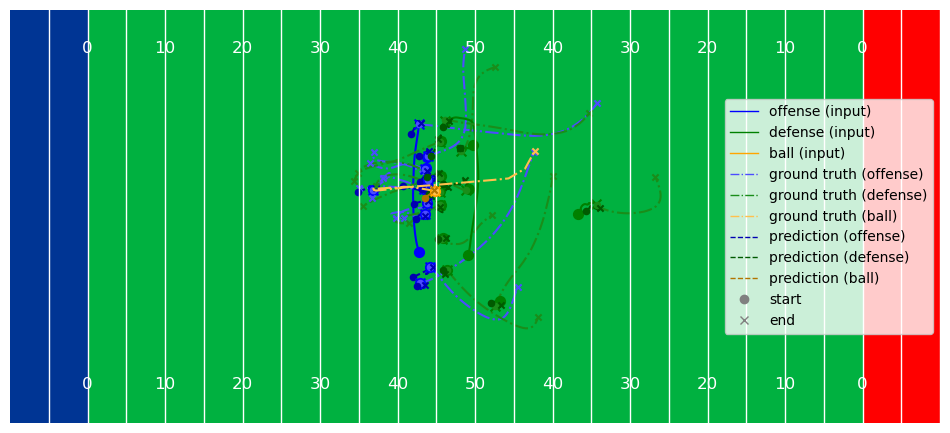

In [ ]:
# Filter to test rows and pick one at random
N_STEPS = 40

row = (
    df
    .loc[df['split'] == "test", ['gameId', 'playId']]
    .sample(n=1) 
)

# Extract into Python variables
gameId = row['gameId'].iloc[0]
playId = row['playId'].iloc[0]

print(f"Selected gameId = {gameId}, playId = {playId}")

context_seq, gt_future = load_play(
    parquet_path="../../processed_data/model_input_2.parquet",
    game_id=gameId,
    play_id=playId,
    ctx_len=100,
    n_future=N_STEPS,
)

pred = model.predict(context_seq, verbose=0)

_ = custom_visualizer.plot_trajectories(
        sequence=context_seq[0],
        ground_truth_seq=gt_future,
        pred_seq=pred,
        offense='all', defense='all', include_ball=True)

In [ ]:
%%time

N_STEPS = 40

# Grab only test split ids
ids_in_test = game_indexer.loc[game_indexer['split'] == "test", ['gameId', 'playId']][:100]

# Will hold an (n_plays, N_STEPS) array of L2 errors
all_errors = []

# Loop over every play in the test set
for gameId, playId in tqdm(ids_in_test.values, desc="Evaluating plays"):
    # load context + ground truth future
    context_seq, gt_future = load_play(
        parquet_path="../../processed_data/model_input_2.parquet",
        game_id=gameId,
        play_id=playId,
        ctx_len=100,
        n_future=N_STEPS,
    )

    # Skip if sequence is empty
    if context_seq is None or gt_future is None:
        continue
    # Skip if sequence is all zeros
    if np.all(context_seq == 0) or np.all(gt_future == 0):
        continue
    # Skip if gt_future is less than N_STEPS
    if gt_future.shape[1] < N_STEPS:
        continue

    # Calculate length of the sequence to be predicted
    seq_len = gt_future.shape[1]  # (100, 46)
    
    # autoregressive prediction
    pred = model.predict(context_seq, verbose=0)  # (1, 40, 46)
    
    # ground-truth for those same steps
    gt = gt_future[0]                                       # (N_STEPS, 46)
    
    # per-frame Euclidean distance (add small eps for stability)
    dists = np.sqrt(np.sum((pred - gt)**2, axis=-1) + 1e-6)  # (N_STEPS,)
    
    all_errors.append(dists)

all_errors = np.stack(all_errors)  # shape = (n_plays, N_STEPS)

# mean error at each future step
mean_error_per_step = all_errors.mean(axis=0)  # (N_STEPS,)

# overall mean error (averaged across all plays & steps)
overall_mean_error = all_errors.mean()

print(f"\nOverall mean Euclidean error (all plays & steps): {overall_mean_error:.4f}")
print(f"\nMultiplied by 120: {overall_mean_error * 120:.4f}")


Evaluating plays: 100%|██████████| 100/100 [00:05<00:00, 17.79it/s]


Overall mean Euclidean error (all plays & steps): 0.1878

Multiplied by 120: 22.5373
CPU times: total: 39.1 s
Wall time: 5.63 s
